In [1]:
import jax.numpy as jnp

def fwd_solver(f, z_init):
    z_prev, z = z_init, f(z_init)
    while jnp.linalg.norm(z_prev - z) > 1e-5:
        z_prev, z = z, f(z)
    return z

In [2]:
import jax

def newton_solver(f, z_init):
    f_root = lambda z: f(z) - z
    g = lambda z: z - jnp.linalg.solve(jax.jacobian(f_root)(z), f_root(z))
    return fwd_solver(g, z_init)

In [3]:
def anderson_solver(f, z_init, m=5, lam=1e-4, max_iter=50, tol=1e-5, beta=1.0):
    x0 = z_init
    x1 = f(x0)
    x2 = f(x1)
    X = jnp.concatenate([jnp.stack([x0, x1]), jnp.zeros((m - 2, *jnp.shape(x0)))])
    F = jnp.concatenate([jnp.stack([x1, x2]), jnp.zeros((m - 2, *jnp.shape(x0)))])
    
    res = []
    for k in range(2, max_iter):
        n = min(k, m)
        G = F[:n] - X[:n]
        GTG = jnp.tensordot(G, G, [list(range(1, G.ndim))] * 2)
        H = jnp.block([
            [jnp.zeros((1, 1)), jnp.ones((1, n))],
            [jnp.ones((n, 1)), GTG]
        ]) + lam * jnp.eye(n + 1)
        alpha = jnp.linalg.solve(H, jnp.zeros(n+1).at[0].set(1))[1:]
        
        xk = beta * jnp.dot(alpha, F[:n]) + (1-beta) * jnp.dot(alpha, X[:n])
        X = X.at[k % m].set(xk)
        F = F.at[k % m].set(f(xk))
        
        res = jnp.linalg.norm(F[k % m] - X[k % m]) \
            / (1e-5 + jnp.linalg.norm(F[k % m]))
        if res < tol:
            break
    return xk

In [4]:
def fixed_point_layer(solver, f, params, x):
    z_star = solver(lambda z: f(params, x, z), z_init=jnp.zeros_like(x))
    return z_star

In [5]:
f = lambda W, x, z: jnp.tanh(jnp.dot(W, z) + x)

In [6]:
from jax import random

ndim = 10
W = random.normal(random.PRNGKey(0), (ndim, ndim)) / jnp.sqrt(ndim)
x = random.normal(random.PRNGKey(1), (ndim,))

In [7]:
z_star = fixed_point_layer(fwd_solver, f, W, x)
print(z_star)

[ 0.00649604 -0.7015957  -0.98471504 -0.04196557 -0.61522186 -0.48183814
  0.5783122   0.95567054 -0.08373152  0.8447805 ]


In [8]:
z_star = fixed_point_layer(newton_solver, f, W, x)
print(z_star)

[ 0.00649411 -0.701595   -0.98471504 -0.04196496 -0.6152211  -0.4818384
  0.57831246  0.95567054 -0.08372923  0.8447799 ]


In [9]:
z_star = fixed_point_layer(anderson_solver, f, W, x)
print(z_star)

[ 0.00649835 -0.70159334 -0.9847146  -0.04194273 -0.61521924 -0.48183316
  0.5783229   0.95566976 -0.0837342   0.8447749 ]


In [10]:
# example of naive gradient (the gradient itself is not important)
g = jax.grad(lambda W: fixed_point_layer(fwd_solver, f, W, x).sum())(W)
print(g[0])

[ 0.00756652 -0.8125904  -1.1404797  -0.04861288 -0.7125526  -0.5580556
  0.66978824  1.1068417  -0.0970227   0.97842264]


In [11]:
g = jax.grad(lambda W: fixed_point_layer(newton_solver, f, W, x).sum())(W)
print(g[0])

[ 0.00752136 -0.81257427 -1.1404786  -0.04860303 -0.71253765 -0.5580563
  0.6697908   1.1068398  -0.09697364  0.97840834]


In [12]:
def f(x):
    return jnp.sin(x) * x**2

x = 2.
y = f(x)
print(y)

3.6371899


In [13]:
delta_x = 1.
y, delta_y = jax.jvp(f, (x,), (delta_x,))
print(y)
print(delta_y) # delta_y = df(x) delta_x at x=2, delta_x=1

3.6371899
1.9726026


In [15]:
eps = 1e-4
delta_y_approx = (f(x + eps * delta_x) - f(x)) / eps
print(delta_y_approx)

1.9741058


In [16]:
# this is basically how jax.grad is defined
def grad(f):
    def gradfun(x):
        _, f_vjp = jax.vjp(f, x)
        grad_val, = f_vjp(1.)
        return grad_val
    return gradfun

In [18]:
def f(x):
    return jnp.sin(x) * x**2

x = 2.
y = f(x)
print(y)

3.6371899


In [19]:
w = 1.
y, f_vjp = jax.vjp(f, x)
lmbda, = f_vjp(w)
print(y)
print(lmbda)

3.6371899
1.9726026


In [21]:
# JVPs and function composition
h = jnp.sin
g = lambda x: x**3

def f_jvp(x, delta_x):
    y, delta_y = jax.jvp(h, (x,), (delta_x,))
    z, delta_z = jax.jvp(g, (y,), (delta_y,))
    return z, delta_z
    
z, delta_z = f_jvp(1., 1.)
print(z)
print(delta_z)

0.59582335
1.147721


In [22]:
# check against jax.jvp applied to f
f = lambda x: g(h(x))
z, delta_z = jax.jvp(f, (1.,), (1.,))
print(z)
print(delta_z)

0.59582335
1.147721


In [26]:
def f_vjp(x, w):
    
    # "forward pass"
    y, h_vjp = jax.vjp(h, x)
    z, g_vjp = jax.vjp(g, y)
    
    # "backward pass"
    lmbda_y, = g_vjp(w)
    lmbda_x, = h_vjp(lmbda_y)
    
    return z, lmbda_x

z, lmbda = f_vjp(1., 1.)
print(z)
print(lmbda)

0.59582335
1.147721


In [27]:
# check against jax.vjp applied to f
z, f_vjp_ = jax.vjp(f, 1.)
lmbda, = f_vjp_(1.)
print(z)
print(lmbda)

0.59582335
1.147721


In [32]:
from functools import partial

# implement implicit layer in jax using implicit function theorem

@partial(jax.custom_vjp, nondiff_argnums=(0, 1))
def fixed_point_layer(solver, f, params, x):
    z_star = solver(lambda z: f(params, x, z), z_init=jnp.zeros_like(x))
    return z_star

def fixed_point_layer_fwd(solver, f, params, x):
    z_star = fixed_point_layer(solver, f, params, x)
    return z_star, (params, x, z_star)

def fixed_point_layer_bwd(solver, f, res, z_star_bar):
    params, x, z_star = res
    _, vjp_a = jax.vjp(lambda params, x: f(params, x, z_star), params, x)
    _, vjp_z = jax.vjp(lambda z: f(params, x, z), z_star)
    return vjp_a(solver(
        lambda u: vjp_z(u)[0] + z_star_bar,
        z_init=jnp.zeros_like(z_star)
    ))

fixed_point_layer.defvjp(fixed_point_layer_fwd, fixed_point_layer_bwd)

In [40]:
f = lambda W, x, z: jnp.tanh(jnp.dot(W, z) + x)

ndim = 10
W = random.normal(random.PRNGKey(0), (ndim, ndim)) / jnp.sqrt(ndim)
x = random.normal(random.PRNGKey(1), (ndim,))

In [41]:
# test the gradient
g = jax.grad(lambda W: fixed_point_layer(fwd_solver, f, W, x).sum())(W)
print(g[0])

[ 0.00752357 -0.8125729  -1.1404755  -0.04860361 -0.7125366  -0.55805445
  0.6697886   1.1068368  -0.09697603  0.97840637]


In [42]:
g = jax.grad(lambda W: fixed_point_layer(newton_solver, f, W, x).sum())(W)
print(g[0])

[ 0.00752136 -0.8125742  -1.1404786  -0.04860303 -0.7125376  -0.55805624
  0.6697907   1.1068398  -0.09697363  0.9784083 ]


In [43]:
g = jax.grad(lambda W: fixed_point_layer(anderson_solver, f, W, x).sum())(W)
print(g[0])

[ 0.00752613 -0.8125576  -1.1404574  -0.04857641 -0.7125225  -0.55804
  0.6697906   1.1068188  -0.09697763  0.9783848 ]


In [52]:
# JAX specific optimizations
from jax import lax

def fwd_solver(f, z_init):
    def cond_fun(carry):
        z_prev, z = carry
        return jnp.linalg.norm(z_prev - z) > 1e-5

    def body_fun(carry):
        _, z = carry
        return z, f(z)

    init_carry = (z_init, f(z_init))
    _, z_star = lax.while_loop(cond_fun, body_fun, init_carry)
    return z_star

In [57]:
def anderson_solver(f, z_init, m=5, lam=1e-4, max_iter=50, tol=1e-5, beta=1.0):
    x0 = z_init
    x1 = f(x0)
    x2 = f(x1)
    X = jnp.concatenate([jnp.stack([x0, x1]), jnp.zeros((m - 2, *jnp.shape(x0)))])
    F = jnp.concatenate([jnp.stack([x1, x2]), jnp.zeros((m - 2, *jnp.shape(x0)))])

    def step(n, k, X, F):
        G = F[:n] - X[:n]
        GTG = jnp.tensordot(G, G, [list(range(1, G.ndim))] * 2)
        H = jnp.block([[jnp.zeros((1, 1)), jnp.ones((1, n))],
                      [ jnp.ones((n, 1)), GTG]]) + lam * jnp.eye(n + 1)
        alpha = jnp.linalg.solve(H, jnp.zeros(n+1).at[0].set(1))[1:]

        xk = beta * jnp.dot(alpha, F[:n]) + (1-beta) * jnp.dot(alpha, X[:n])
        X = X.at[k % m].set(xk)
        F = F.at[k % m].set(f(xk))
        return X, F

    # unroll the first m steps
    for k in range(2, m):
        X, F = step(k, k, X, F)
        res = jnp.linalg.norm(F[k] - X[k]) / (1e-5 + jnp.linalg.norm(F[k]))
        if res < tol or k + 1 >= max_iter:
            return X[k], k

    # run the remaining steps in a lax.while_loop
    def body_fun(carry):
        k, X, F = carry
        X, F = step(m, k, X, F)
        return k + 1, X, F

    def cond_fun(carry):
        k, X, F = carry
        kmod = (k - 1) % m
        res = jnp.linalg.norm(F[kmod] - X[kmod]) / (1e-5 + jnp.linalg.norm(F[kmod]))
        return (k < max_iter) & (res >= tol)

    k, X, F = lax.while_loop(cond_fun, body_fun, (k + 1, X, F))
    return X[(k - 1) % m]

In [54]:
z_star = fixed_point_layer(fwd_solver, f, W, x)
print(z_star)

[ 0.00649604 -0.7015957  -0.98471504 -0.04196557 -0.61522186 -0.48183814
  0.5783122   0.95567054 -0.08373152  0.8447805 ]


In [55]:
z_star = fixed_point_layer(newton_solver, f, W, x)
print(z_star)

[ 0.00649411 -0.701595   -0.98471504 -0.04196496 -0.6152211  -0.4818384
  0.57831246  0.95567054 -0.08372923  0.8447799 ]


In [58]:
z_star = fixed_point_layer(anderson_solver, f, W, x)
print(z_star)

[ 0.00649835 -0.70159334 -0.9847146  -0.04194273 -0.61521924 -0.48183316
  0.5783229   0.95566976 -0.0837342   0.8447749 ]


In [59]:
# check implicit diff again
g = jax.grad(lambda W: fixed_point_layer(fwd_solver, f, W, x).sum())(W)
print(g[0])

[ 0.00752357 -0.8125729  -1.1404755  -0.04860361 -0.7125366  -0.55805445
  0.6697886   1.1068368  -0.09697603  0.97840637]


In [60]:
g = jax.grad(lambda W: fixed_point_layer(newton_solver, f, W, x).sum())(W)
print(g[0])

[ 0.00752136 -0.8125742  -1.1404786  -0.04860303 -0.7125376  -0.55805624
  0.6697907   1.1068398  -0.09697363  0.9784083 ]


In [61]:
g = jax.grad(lambda W: fixed_point_layer(anderson_solver, f, W, x).sum())(W)
print(g[0])

[ 0.00752613 -0.8125576  -1.1404574  -0.04857641 -0.7125225  -0.55804
  0.6697906   1.1068188  -0.09697763  0.9783848 ]


In [64]:
# now on to ODEs
from jax.experimental.ode import odeint

def f(state, t, rho, sigma, beta):
    x, y, z = state
    return jnp.array([
        sigma*(y - x),
        x*(rho - z) - y,
        x*y - beta*z
    ])

ys = odeint(
    partial(f, rho=28., sigma=10., beta=8./3),
    y0=jnp.array([1., 1., 1.]),
    t=jnp.linspace(0, 10., 10000)
)

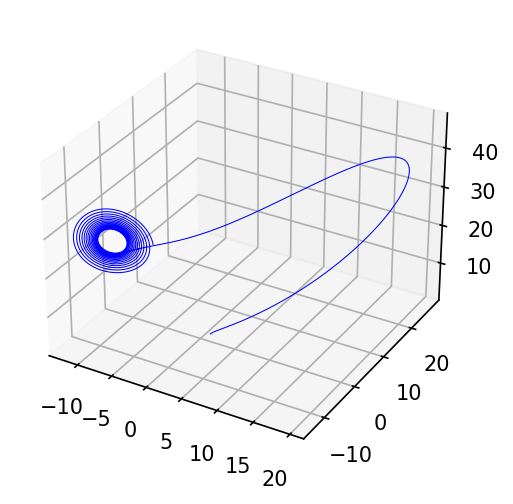

In [65]:
import matplotlib.pyplot as plt

def plot_3d_path(ax, ys, color):
  x0, x1, x2 = ys.T
  ax.plot(x0, x1, x2, lw=0.5, color=color)

fig = plt.figure(figsize=(6, 4), dpi=150)
ax = fig.gca(projection='3d')
plot_3d_path(ax, ys, 'b');

In [67]:
from jax import lax

def odeint_euler(f, y0, t, *args):
    def step(state, t):
        y_prev, t_prev = state
        dt = t - t_prev
        y = y_prev + dt * f(y_prev, t_prev, *args)
        return (y, t), y
    _, ys = lax.scan(step, (y0, t[0]), t[1:])
    return ys

ys = odeint_euler(
    f, jnp.array([-2., -2., -2.]), jnp.linspace(0, 10., 10000), 28., 10., 8./3
)

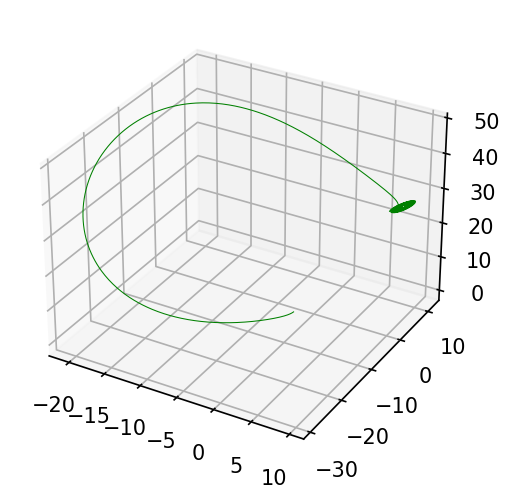

In [68]:
fig = plt.figure(figsize=(6, 4), dpi=150)
ax = fig.gca(projection='3d')
plot_3d_path(ax, ys, 'g')

In [69]:
# 4th order Runge-Kutta

def odeint_rk4(f, y0, t, *args):
    def step(state, t):
        y_prev, t_prev = state
        h = t - t_prev
        k1 = h * f(y_prev, t_prev, *args)
        k2 = h * f(y_prev + k1/2., t_prev + h/2., *args)
        k3 = h * f(y_prev + k2/2., t_prev + h/2., *args)
        k4 = h * f(y_prev + k3/2., t + h, *args)
        y = y_prev + 1./6 * (k1 + 2*k2 + 2*k3 + k4)
        return (y, t), y
    _, ys = lax.scan(step, (y0, t[0]), t[1:])
    return ys
    

In [70]:
ys = odeint_rk4(f, jnp.array([5., 5., 5.]), jnp.linspace(0, 10., 10000),
                28., 10., 8./3)

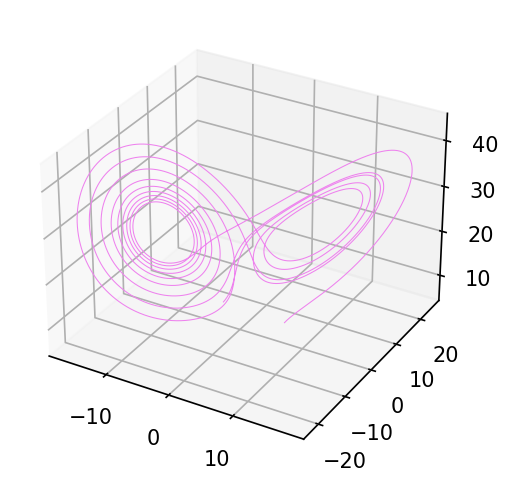

In [71]:
fig = plt.figure(figsize=(6, 4), dpi=150)
ax = fig.gca(projection='3d')
plot_3d_path(ax, ys, 'violet');

In [76]:
odeint_rk4 = jax.custom_jvp(odeint_rk4, nondiff_argnums=(0,))

@odeint_rk4.defjvp
def odeint_rk4_jvp(f, primals, tangents):
    y0, t, *args = primals
    delta_y0, _, *delta_args = tangents
    nargs = len(args)
    
    def f_aug(aug_state, t, *args_and_delta_args):
        primal_state, tangent_state = aug_state
        args = args_and_delta_args[:nargs]
        delta_args = args_and_delta_args[nargs:]
        primal_dot, tangent_dot = jax.jvp(
            f, (primal_state, t, *args), (tangent_state, 0., *delta_args)
        )
        return jnp.stack([primal_dot, tangent_dot])
    
    aug_init_state = jnp.stack([y0, delta_y0])
    aug_states = odeint_rk4(f_aug, aug_init_state, t, *args, *delta_args)
    ys, ys_dot = aug_states[:, 0, :], aug_states[:, 1, :]
    return ys, ys_dot


In [77]:
def evolve(y0):
    return odeint_rk4(f, y0, jnp.linspace(0, 1., 1000), 28., 10., 8./3)

y0 = jnp.array([5., 5., 5.])
delta_y0 = jnp.array([0., 0., 1.])
ys, delta_ys = jax.jvp(evolve, (y0,), (delta_y0,))

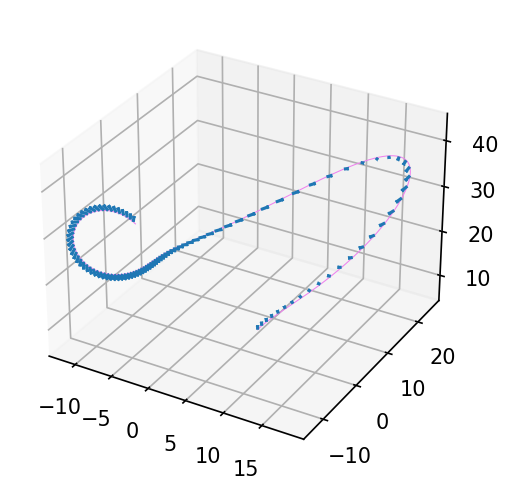

In [78]:
def plot_3d_path_with_delta(ax, ys, delta_ys, color):
    x0, x1, x2 = ys.T
    dx0, dx1, dx2 = delta_ys.T

    skip = 10
    ax.plot(x0, x1, x2, lw=0.5, color=color)
    ax.quiver(x0[::skip], x1[::skip], x2[::skip], dx0[::skip], dx1[::skip], dx2[::skip])

fig = plt.figure(figsize=(6, 4), dpi=150)
ax = fig.gca(projection='3d')
plot_3d_path_with_delta(ax, ys, delta_ys, 'violet')

In [79]:
def evolve(y0, rho, sigma, beta):
  return odeint_rk4(f, y0, jnp.linspace(0, 1., 1000), rho, sigma, beta)

y0 = jnp.array([5., 5., 5.])
delta_y0 = jnp.array([0., 0., 0.])

rho = 28.
sigma = 10.
beta = 8./3

delta_rho = 0.
delta_sigma = 1.
delta_beta = 0.

ys, delta_ys = jax.jvp(
    evolve,
    (y0, rho, sigma, beta),
    (delta_y0, delta_rho, delta_sigma, delta_beta)
)

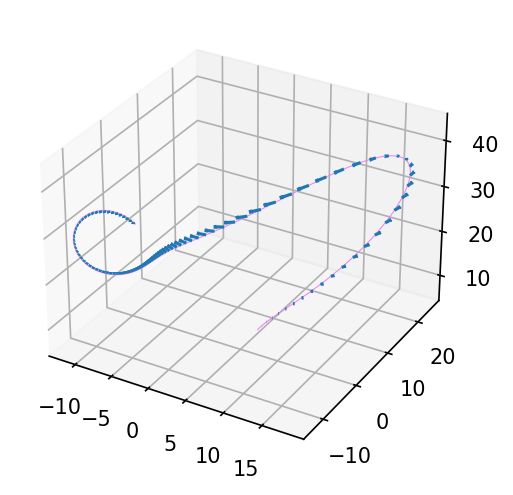

In [80]:
fig = plt.figure(figsize=(6, 4), dpi=150)
ax = fig.gca(projection='3d')
plot_3d_path_with_delta(ax, ys, delta_ys, 'violet')

In [81]:
delta_rho = 0.
delta_sigma = 0.
delta_beta = 1.

ys, delta_ys = jax.jvp(evolve,
                       (y0, rho, sigma, beta),
                       (delta_y0, delta_rho, delta_sigma, delta_beta))

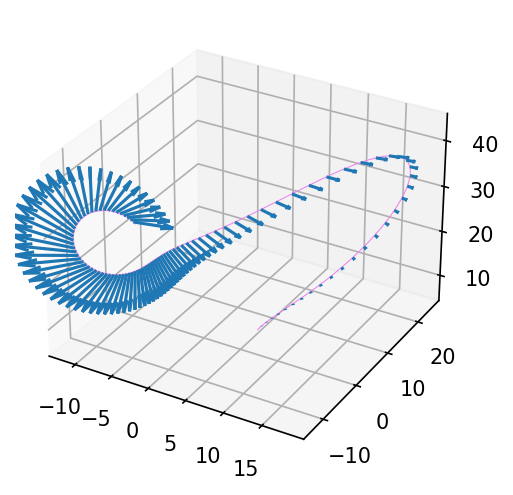

In [82]:
fig = plt.figure(figsize=(6, 4), dpi=150)
ax = fig.gca(projection='3d')
plot_3d_path_with_delta(ax, ys, delta_ys, 'violet')

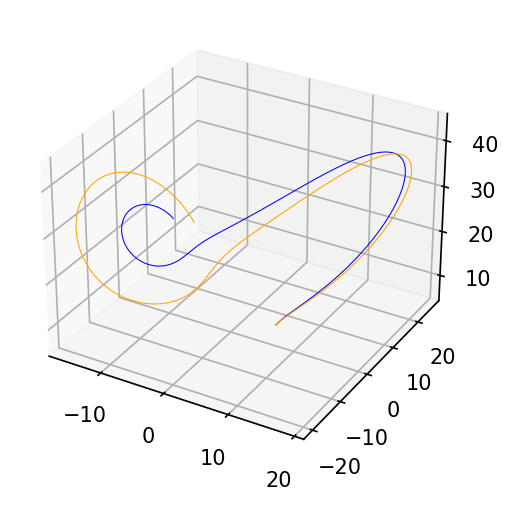

In [83]:
# verify that trajectory is actually sensitive to beta parameter

perturbed_ys = evolve(y0, rho, sigma, beta + 1.)

fig = plt.figure(figsize=(6, 4), dpi=150)
ax = fig.gca(projection='3d')
plot_3d_path(ax, ys, 'blue')
plot_3d_path(ax, perturbed_ys, 'orange')